In [1]:
using GLM
using DataFrames
using Random
using Parquet
import YAML
using Term: install_term_logger, install_term_repr, install_term_stacktrace
using Plots

install_term_stacktrace()
install_term_repr()
install_term_logger()

base_folder = raw"D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\GLM"
metadata = YAML.load_file(joinpath(base_folder, "metadata.yaml"))

@info "Loaded $(length(metadata)) metadata entries"

@Info (Main):  Loaded 24 metadata entries 
  ╰──────────────────────────────────────────────── 
                      Wed, 15 Jun 2022 18:01:40 


MethodError: MethodError: no method matching get(::Dict{Any, Any}, ::Symbol)
Closest candidates are:
  get(::Dict{K, V}, ::Any, !Matched::Any) where {K, V} at C:\Users\Federico\AppData\Local\Programs\Julia-1.7.2\share\julia\base\dict.jl:506
  get(!Matched::Union{Tables.AbstractColumns, Tables.AbstractRow}, ::Union{Integer, Symbol}, !Matched::Any) at C:\Users\Federico\.julia\packages\Tables\PxO1m\src\Tables.jl:188
  get(!Matched::DataStructures.RobinDict{K, V}, ::Any, !Matched::Any) where {K, V} at C:\Users\Federico\.julia\packages\DataStructures\59MD0\src\robin_dict.jl:384
  ...

In [34]:
doing = collect(values(metadata))[14]

╭──── Dict {Any, Any}  ────────────────────────────────────────────────╮
│                                                                      │
│   {String} │ unit_data  =>        D:\Dropbox ...        │ {String}   │
│   {String} │ recording  => FC_220410_BAA1101192_hairpin │ {String}   │
│   {String} │ glm_fitted =>            false             │  {Bool}    │
│   {String} │    unit    =>             100              │ {Int64}    │
│                                                                      │
╰────────────────────────────────────────────────────────── 4 items ───╯


## Load data

And split for k-folds cross validation

In [35]:
data = DataFrame(read_parquet(doing["unit_data"]));
size(data)

(608937, 21)

In [36]:
# add a column with the fold number of each row (shuffled!)
data.fold = shuffle!((1:nrow(data)) .% 5)  # 5x k-fold

"""
    get_fold_data(df::DataFrame, fold::Int)

Get training/test sets for a fold of the data.

#### Usage
```julia
    trainset, testset = get_fold_data(data, 1)
```

Originally from [here](www.juliabloggers.com/dataframes-jl-training-implementing-cross-validation-2)
"""
get_fold_data(df, fold) =
    (train=view(df, df.fold .!= fold, :),
     test=view(df, df.fold .== fold, :))


get_fold_data

## Define formulas
Three classess of formulas:
1. complete
2. missing a single variable (one per variable)
3. missing a variables class (speed, ang. vel, curvature)

In [37]:

Y = Term(:p_spike)
variables = Term.([
    :v, :v_squared, :dv_250ms, :dv_500ms, :dv_1000ms, :omega, :omega_squared, :domega_250ms, :domega_500ms, :domega_1000ms, :curv_0cm, :curv_10cm, :curv_20cm, :curv_30cm
])

# have a formula missing each individual predictor
formulas = Dict{String, Any}(
    "missing_$(variables[i])" => (Y ~ sum(variables[1:end .!= i])) for i = 1:length(variables)
)

# have a complete formula
formulas["complete"] = Y  ~ sum(variables)

# have a formula missing each class of predictors
formulas["missing_speed_class"] = @formula(p_spike ~ omega + omega_squared + domega_250ms + domega_500ms + domega_1000ms + curv_0cm + curv_10cm + curv_20cm + curv_30cm)
formulas["missing_curv_class"] = @formula(p_spike ~ v + v_squared + dv_250ms + dv_500ms + dv_1000ms + omega + omega_squared + domega_250ms + domega_500ms + domega_1000ms)
formulas["missing_omega_class"] = @formula(p_spike ~ v + v_squared + dv_250ms + dv_500ms + dv_1000ms + curv_0cm + curv_10cm + curv_20cm + curv_30cm)
formulas

╭──── Dict {String, Any}  ────────────────────────────────────────────────────╮
│                                                                             │
│   {String} │   missing_dv_500ms    => p_spike ~ v + v_squared + ... ...     │
│   {String} │ missing_domega_500ms  => p_spike ~ v + v_squared + ... ...     │
│   {String} │   missing_curv_0cm    => p_spike ~ v + v_squared + ... ...     │
│   {String} │  missing_curv_class   => p_spike ~ v + v_squared + ... ...     │
│   {String} │ missing_domega_1000ms => p_spike ~ v + v_squared + ... ...     │
│   {String} │ missing_domega_250ms  => p_spike ~ v + v_squared + ... ...     │
│   {String} │   missing_curv_20cm   => p_spike ~ v + v_squared + ... ...     │
│   {String} │   missing_v_squared   => p_spike ~ v + dv_250ms + ...  ...     │
│   {String} │   missing_dv_1000ms   => p_spike ~ v + v_squared + ... ...     │
│   {String} │   missing_curv_30cm   => p_spike ~ v + v_squared + ... ...     │
│      ⋮     │           ⋮              

# Fit
and save the models.

In [43]:
train, test = get_fold_data(data, 1)
model = glm(formulas["complete"], train, Binomial(), LogitLink(); atol=1e-10, rtol=1e-10)


StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

p_spike ~ 1 + v + v_squared + dv_250ms + dv_500ms + dv_1000ms + omega + omega_squared + domega_250ms + domega_500ms + domega_1000ms + curv_0cm + curv_10cm + curv_20cm + curv_30cm

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error       z  Pr(>|z|)    Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)       -2.856288957080537   0.038303178332444766  -74.57    <1e-99     -2.931361807105544     -2.7812161070555304
v              -1368.1725073007124     73.16286923315681     -18.70    <1e-77  -1511.5690960033135     -1224.7759185981113
v_squared        467.11909848473687    53.367287520308125       8.75    <1e-17    362.5211369

## Predict
For each model and save some images

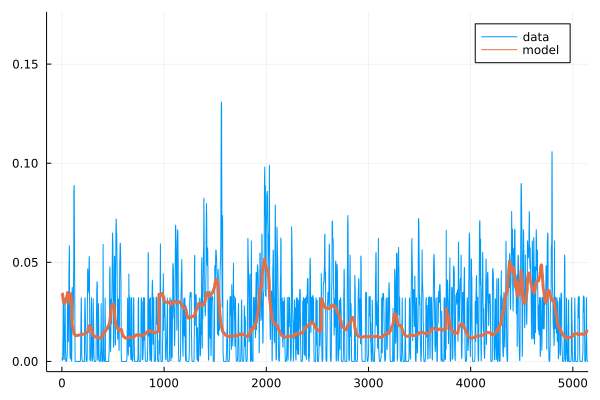

In [44]:
y = test[:, :p_spike]
ŷ = predict(model, test)


plot(y, label="data")

plot!(ŷ, label="model", linewidth=3,)
plot!(xlim=[0, 5000])

In [53]:
DataFrame(coeftable(model))

15×7 DataFrame
 Row │ Name           Coef.        Std. Error  z           Pr(>|z|)     Lower  ⋯
     │ String         Float64      Float64     Float64     Float64      Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ (Intercept)       -2.85629   0.0383032  -74.5705    0.0             -2. ⋯
   2 │ v              -1368.17     73.1629     -18.7004    4.91651e-78  -1511.
   3 │ v_squared        467.119    53.3673       8.75291   2.07919e-18    362.
   4 │ dv_250ms         -66.3768   12.7847      -5.19191   2.0815e-7      -91.
   5 │ dv_500ms         -58.599    15.8476      -3.69765   0.000217606    -89. ⋯
   6 │ dv_1000ms         -7.10355  11.7523      -0.604439  0.545552       -30.
   7 │ omega             16.027    11.5652       1.3858    0.165808        -6.
   8 │ omega_squared     -7.83073   7.82713     -1.00046   0.317087       -23.
   9 │ domega_250ms     -19.4626   10.2962      -1.89028   0.0587203      -39. ⋯
  10 │ domega_500ms      33.1001   12.3842       2.67276   0.00752291       8.
  11 │ domega_1000ms     23.9507   10.4631       2.28907   0.0220752        3.
  12 │ curv_0cm          -9.68753   9.1016      -1.06438   0.287158       -27.
  13 │ curv_10cm         49.8193   10.0682       4.94817   7.49151e-7      30. ⋯
  14 │ curv_20cm         -3.95484  10.7094      -0.369285  0.711916       -24.
  15 │ curv_30cm         18.694     9.85202      1.89748   0.0577652       -0.
                                                               2 columns omitted